In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import os
import time
import mxnet as mx
import numpy as np
from sklearn.datasets import fetch_mldata
from data_factory import RandIter, get_mnist
from utils import plot_latent_variable

In [2]:
def load_pretrained(prefix, epoch):
    sym = mx.sym.load('cache/models/%s.json' % prefix)
    
    arg_params = {}
    aux_params = {}
    for k, v in mx.nd.load('cache/models/%s_%04d.params' % (prefix, epoch)).items():
        tp, name = k.split(':', 1)
        if tp == 'arg':
            arg_params[name] = v
        elif tp == 'aux':
            aux_params[name] = v
    
    return sym, arg_params, aux_params
    

In [3]:
dataset = 'mnist'
task = 'supervised'
epoch = 19
z_prior = 'swiss_roll'
if z_prior == 'uniform':
    z_args = {
        'minv': -2.0,
        'maxv': 2.0
    }
elif z_prior == 'gaussian_mixture':
    z_args = {
        'x_var': 0.5,
        'y_var': 0.1
    }
elif z_prior == 'swiss_roll':
    z_args = {}
elif z_prior == 'gaussian':
    if task == 'supervised':
        raise ValueError, 'please use gaussian mixture for supervised training'
    else:
        z_args = {
            'mean': 0,
            'var': 1
        }
else:
    raise ValueError, 'unknown z_prior'
batch_size = 64
if dataset == 'mnist':
    width = 28
    height = 28
else:
    raise NotImplementedError
data_shapes = (batch_size, 1, height, width)
ctx = mx.gpu(3)

enc_sym, enc_arg_params, enc_aux_params = load_pretrained('%s_%s_enc_%s' % (dataset, z_prior, task), epoch)
mod_enc = mx.mod.Module(symbol=enc_sym, data_names=('data',), label_names=(), context=ctx)
mod_enc.bind(data_shapes=[('data', data_shapes)])
mod_enc.init_params(arg_params=enc_arg_params, aux_params=enc_aux_params)
Z = enc_sym.infer_shape(data=data_shapes)[1][0][1]

dec_sym, dec_arg_params, dec_aux_params = load_pretrained('%s_%s_dec_%s' % (dataset, z_prior, task), epoch)
mod_dec = mx.mod.Module(symbol=dec_sym, data_names=('z',), label_names=('data',), context=ctx)
mod_dec.bind(data_shapes=[('z', (batch_size, Z))], label_shapes=[('data', data_shapes)])
mod_dec.init_params(arg_params=dec_arg_params, aux_params=dec_aux_params)

# dis_sym, dis_arg_params, dis_aux_params = load_pretrained('%s_%s_dis' % (dataset, z_prior), epoch-1)
# mod_dis = mx.mod.Module(symbol=dis_sym, data_names=('z',), label_names=('label_pq',), context=ctx)
# mod_dis.bind(data_shapes=[('z', (batch_size, Z))], label_shapes=[('label_pq', (batch_size,))])
# mod_dis.init_params(arg_params=dis_arg_params, aux_params=dis_aux_params)

In [4]:
if dataset == 'mnist':
    X_train, X_test, Y_train, Y_test = get_mnist(root_dir='./cache', train_ratio=0.8)
    train_iter = mx.io.NDArrayIter(X_train, Y_train, batch_size=batch_size)
else:
    raise NotImplementedError
rand_iter = RandIter(batch_size, Z, z_prior=z_prior, n_labels=10, with_label=True if task=='supervised' else False, **z_args)

### Visualize the latent variable from p(z)

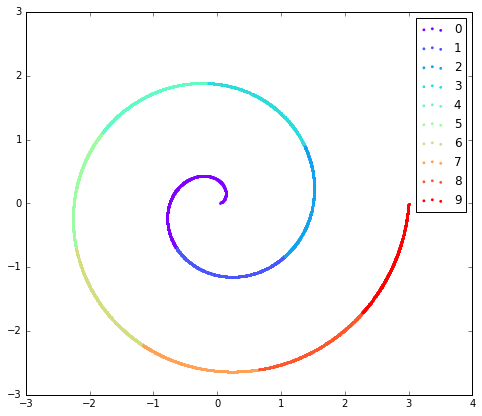

In [5]:
batch_num = 100
z_buf = []
label_buf = []
for i in xrange(batch_num):
    rbatch = rand_iter.next()
    pz = rbatch.data[0].asnumpy()
    if task == 'supervised':
        label_buf.append(rbatch.label[0].asnumpy().argmax(axis=1))
    z_buf.append(pz)
pz = np.vstack(z_buf)

if task == 'supervised':
    label = np.hstack(label_buf)
    plot_latent_variable(pz, label)
else:
    if pz.shape[1] == 2:
        plt.figure(figsize=(8, 8))
        plt.axes().set_aspect('equal')
        plt.scatter(pz[:, 0], pz[:, 1], linewidth=0, s=8)
        plt.title('p(z)')
        plt.show

### Visualize the latent variable from q(z)

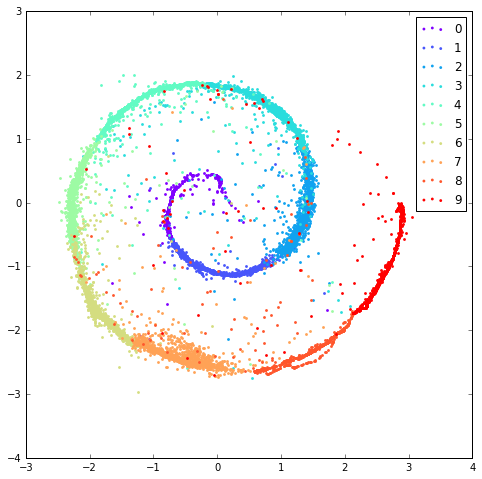

12800 samples


In [6]:
batch_num = 200
z_buf = []
label_buf = []
train_iter.reset()
for i in xrange(batch_num):
    batch = train_iter.next()
    mod_enc.forward(mx.io.DataBatch(batch.data, []), is_train=False)
    qz = mod_enc.get_outputs()
    z_buf.append(qz[0].asnumpy().copy())
    label_buf.append(batch.label[0].asnumpy().copy())

# display.display(plt.gcf())
# display.clear_output(wait=True)
X = np.vstack(z_buf)
Y = np.hstack(label_buf)
plot_latent_variable(X, Y)
print '%d samples' % (X.shape[0])

### Visualize the distribution of output images from p(z)

Generate all samples needed in 0.0074s
Plot image in 0.0739s


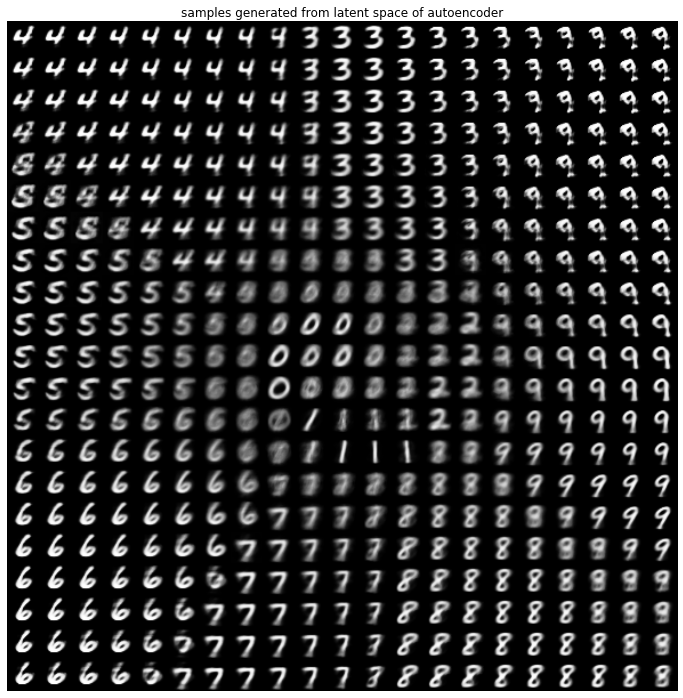

In [7]:
t1 = time.time()
z_arr = np.mgrid[4:-4.2:-0.4, -4:4.2:0.4]
_, N, M = z_arr.shape
z_arr = z_arr.reshape(2, -1).T[:, ::-1].astype(np.float32)
dec_out_list = []
for i in xrange(int(np.ceil(z_arr.shape[0]*1.0/batch_size))):
    data_arr = np.zeros((batch_size, Z),dtype=np.float32)
    z_tmp = z_arr[i*batch_size:min((i+1)*batch_size, z_arr.shape[0]), :]
    data_arr[:len(z_tmp)] = z_tmp[...]
    batch = mx.io.DataBatch([mx.nd.array(data_arr)], label=[])
    mod_dec.forward(batch, is_train=False)
    dec_out = mod_dec.get_outputs()[0].asnumpy()[:len(z_tmp)]
    dec_out_list.append(dec_out)
X = np.vstack(dec_out_list).reshape(-1, height, width)
t2 = time.time()
print 'Generate all samples needed in %.4fs' % (t2-t1)

fig = plt.figure(1, (12., 12.))
ax1 = plt.axes(frameon=False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.title('samples generated from latent space of autoencoder')
im_buf = np.zeros((N*height, M*width), dtype=np.uint8)
for i, x in enumerate(X):
    img = (x * 255).astype(np.uint8)
    n = i/M
    m = i%M
    im_buf[n*height:(n+1)*height, m*width:(m+1)*width] = img

plt.imshow(im_buf, cmap='Greys_r')
t3 = time.time()
print 'Plot image in %.4fs' % (t3-t2)
plt.show()